In [2]:
# Install required packages
!pip install wget
!pip install open3d
!pip install ultralytics  # For YOLOv8
!pip install matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=7dd5da35571f1d908b2af0220504d5b024232ce049ffe0023158f19de1e3d20c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbext

In [3]:
# Download the dataset
import os
import wget
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%cd /content/drive/My Drive/
download_path = "/content/drive/MyDrive/CameraLidarFusion"
os.makedirs(download_path, exist_ok=True)

import shutil

Mounted at /content/drive
/content/drive/My Drive


In [4]:
# Clear previous contents
fusion_dir = "/content/drive/MyDrive/CameraLidarFusion"
if os.path.exists(fusion_dir):
    shutil.rmtree(fusion_dir)
    print(f"Cleared all contents of {fusion_dir}")
os.makedirs(fusion_dir, exist_ok=True)
print(f"Recreated empty directory {fusion_dir}")

Cleared all contents of /content/drive/MyDrive/CameraLidarFusion
Recreated empty directory /content/drive/MyDrive/CameraLidarFusion


In [5]:
# Download KITTI data
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip -P /content/drive/MyDrive/CameraLidarFusion/
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip -P /content/drive/MyDrive/CameraLidarFusion/
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_tracklets.zip -P /content/drive/MyDrive/CameraLidarFusion/

--2025-04-03 19:54:34--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.136.232, 52.219.171.221, 52.219.169.193, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.136.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458643963 (437M) [application/zip]
Saving to: ‘/content/drive/MyDrive/CameraLidarFusion/2011_09_26_drive_0001_sync.zip’

2011_09_26_drive_00 100%[===================>] 437.40M  20.4MB/s    in 23s     

2025-04-03 19:54:59 (18.7 MB/s) - ‘/content/drive/MyDrive/CameraLidarFusion/2011_09_26_drive_0001_sync.zip’ saved [458643963/458643963]

--2025-04-03 19:54:59--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.3, 52.219.171.185, 3.5.137.202, ...
Connecting to s3.e

In [6]:
# Unzip files
import zipfile
sync_zip = "/content/drive/MyDrive/CameraLidarFusion/2011_09_26_drive_0001_sync.zip"
calib_zip = "/content/drive/MyDrive/CameraLidarFusion/2011_09_26_calib.zip"
tracklet_zip = "/content/drive/MyDrive/CameraLidarFusion/2011_09_26_drive_0001_tracklets.zip"
for zip_path in [sync_zip, calib_zip, tracklet_zip]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/drive/MyDrive/CameraLidarFusion/")
    print(f"Unzipped {zip_path}")

Unzipped /content/drive/MyDrive/CameraLidarFusion/2011_09_26_drive_0001_sync.zip
Unzipped /content/drive/MyDrive/CameraLidarFusion/2011_09_26_calib.zip
Unzipped /content/drive/MyDrive/CameraLidarFusion/2011_09_26_drive_0001_tracklets.zip


In [7]:
# Main processing code
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
import glob
import struct
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
# KITTI data paths
base_dir = "/content/drive/MyDrive/CameraLidarFusion/2011_09_26/2011_09_26_drive_0001_sync"
calib_dir = "/content/drive/MyDrive/CameraLidarFusion/2011_09_26"
image_files = sorted(glob.glob(f"{base_dir}/image_02/data/*.png"))
point_files = sorted(glob.glob(f"{base_dir}/velodyne_points/data/*.bin"))
calib_files = sorted(glob.glob(f"{calib_dir}/calib_*.txt"))

In [9]:
# Load a single frame (index 10 for objects)
index = 10  # Frame 10 to ensure objects are present
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)

In [10]:
# Load KITTI LiDAR (.bin to NumPy)
def load_kitti_bin(file_path):
    points = []
    with open(file_path, "rb") as f:
        while True:
            byte = f.read(16)  # 4 floats * 4 bytes each = 16 bytes per point
            if not byte:
                break
            x, y, z, intensity = struct.unpack("ffff", byte)
            points.append([x, y, z])
    return np.array(points)

points_3d_full = load_kitti_bin(point_files[index])

In [11]:
# Simulate 2D LiDAR by filtering to a plane (e.g., z ≈ 1.65m, adjust as needed)
z_plane = 1.65  # Typical KITTI LiDAR height
mask_2d = np.abs(points_3d_full[:, 2] - z_plane) < 0.1  # ±10cm tolerance
lidar_2d = points_3d_full[mask_2d, :2]  # [x, y] only

In [23]:
# LiDAR2Camera class (with updated method)
class LiDAR2Camera:
    def __init__(self, calib_dir):
        calibs = self.read_all_calib_files(calib_dir)
        self.P = np.reshape(calibs["P_rect_02"], [3, 4])  # Rectified projection for camera 2
        R = np.reshape(calibs["R"], [3, 3])  # Rotation from velo to cam
        T = np.reshape(calibs["T"], [3, 1])  # Translation from velo to cam
        self.V2C = np.hstack((R, T))  # 3x4 transformation matrix
        self.R0 = np.eye(3)  # Skip R_rect_00 since P_rect_02 is already rectified
        self.V2C_homo = np.vstack((self.V2C, [0, 0, 0, 1]))

    def read_all_calib_files(self, calib_dir):
        data = {}
        for calib_file in glob.glob(f"{calib_dir}/calib_*.txt"):
            with open(calib_file, "r") as f:
                for line in f.readlines():
                    line = line.rstrip()
                    if len(line) == 0:
                        continue
                    key, value = line.split(":", 1)
                    try:
                        data[key.strip()] = np.array([float(x) for x in value.split()])
                    except ValueError:
                        continue
        return data

    def cart2hom(self, pts_3d):
        return np.hstack((pts_3d, np.ones((pts_3d.shape[0], 1))))

    def project_velo_to_image(self, pts_3d):
        pts_3d_homo = self.cart2hom(pts_3d)  # [N, 4]
        cam_coords = np.dot(self.V2C_homo, pts_3d_homo.T).T  # [N, 4], LiDAR to camera
        # Filter points behind the camera (z <= 0)
        mask = cam_coords[:, 2] > 0
        cam_coords = cam_coords[mask]
        # Project to image plane
        img_coords = np.dot(self.P, cam_coords.T).T  # [N, 3]
        pts_2d = img_coords[:, :2] / img_coords[:, 2:3]  # [N, 2]
        return pts_2d, mask, cam_coords

    def show_lidar_on_image(self, pts_3d, img):
        pts_2d, mask, cam_coords = self.project_velo_to_image(pts_3d)
        pts_3d = pts_3d[mask]  # Filter points based on mask
        img_copy = img.copy()
        # Color-code points by depth (x-coordinate in LiDAR frame, forward distance)
        depths = pts_3d[:, 0]  # Use x for depth (forward distance)
        max_depth = 30.0  # Reduced to better distribute colors

        # Debug: Check for invalid depth values
        if np.any(np.isnan(depths)) or np.any(np.isinf(depths)):
            print("Warning: Invalid depth values detected (nan or inf).")
            depths = np.nan_to_num(depths, nan=0.0, posinf=max_depth, neginf=0.0)

        # Downsample points to reduce density
        step = 5  # Process every 5th point
        for i, (u, v) in enumerate(pts_2d[::step]):
            i_original = i * step  # Map back to original index
            if 0 <= u < img.shape[1] and 0 <= v < img.shape[0]:
                depth = depths[i_original]
                if depth <= 0:
                    continue
                # Normalize depth for color mapping
                color_idx = min(depth / max_depth, 1.0)  # 0 to 1
                if not 0 <= color_idx <= 1:
                    print(f"Invalid color_idx: {color_idx} for depth {depth}")
                    continue

                # Manual color gradient: Green -> Yellow -> Orange -> Red
                if color_idx < 0.33:  # Green to Yellow
                    r = int(255 * (color_idx / 0.33))
                    g = 255
                    b = 0
                elif color_idx < 0.66:  # Yellow to Orange
                    r = 255
                    g = int(255 - (color_idx - 0.33) / 0.33 * 90)  # 255 to 165
                    b = 0
                else:  # Orange to Red
                    r = 255
                    g = int(165 - (color_idx - 0.66) / 0.34 * 165)  # 165 to 0
                    b = 0

                color = (r, g, b)
                # Debug: Print color for first few points
                if i < 5:
                    print(f"Point {i_original}: depth = {depth}, color_idx = {color_idx}, color = {color}")

                cv2.circle(img_copy, (int(u), int(v)), 1, color, -1)  # Smaller points
        return img_copy, pts_2d, pts_3d  # Return pts_2d and pts_3d for BEV

    def fuse_2d_lidar_depth(self, lidar_2d, points_3d_full, img_shape):
        # Project the full 3D point cloud to create a depth map
        pts_2d_full, mask_full, _ = self.project_velo_to_image(points_3d_full)
        points_3d_full = points_3d_full[mask_full]
        depth_map = np.zeros(img_shape[:2])
        for i, (u, v) in enumerate(pts_2d_full):
            if 0 <= u < img_shape[1] and 0 <= v < img_shape[0]:
                depth_map[int(v), int(u)] = max(depth_map[int(v), int(u)], points_3d_full[i, 0])

        # If no 2D LiDAR points, return full point cloud
        if len(lidar_2d) == 0:
            print("No 2D LiDAR points to fuse; returning full 3D point cloud.")
            return points_3d_full

        # Extend 2D LiDAR points to 3D by adding a zero z-coordinate
        lidar_3d = np.hstack((lidar_2d, np.zeros((lidar_2d.shape[0], 1))))
        pts_2d, mask, _ = self.project_velo_to_image(lidar_3d)
        lidar_3d = lidar_3d[mask]

        points_3d = []
        for i, (u, v) in enumerate(pts_2d):
            u_int, v_int = int(u), int(v)
            if 0 <= u_int < img_shape[1] and 0 <= v_int < img_shape[0] and depth_map[v_int, u_int] > 0:
                z = depth_map[v_int, u_int]
                points_3d.append([lidar_2d[i, 0], lidar_2d[i, 1], z])

        if len(points_3d) == 0:
            print("No 2D LiDAR points were fused with depth; returning full 3D point cloud.")
            return points_3d_full

        return np.vstack((points_3d, points_3d_full))

In [24]:
lidar2cam = LiDAR2Camera(calib_dir)

In [25]:
# Fuse 2D LiDAR with depth
points_3d = lidar2cam.fuse_2d_lidar_depth(lidar_2d, points_3d_full, image.shape)
print(f"Generated 3D point cloud with {len(points_3d)} points")

Generated 3D point cloud with 61411 points


In [26]:
# Map LiDAR points to image (use full 3D point cloud for better density)
try:
    img_with_lidar, pts_2d, pts_3d = lidar2cam.show_lidar_on_image(points_3d_full, image)
except Exception as e:
    print(f"Error in show_lidar_on_image: {e}")
    raise

Point 0: depth = 76.02899932861328, color_idx = 1.0, color = (255, 0, 0)
Point 5: depth = 64.78399658203125, color_idx = 1.0, color = (255, 0, 0)
Point 10: depth = 75.98400115966797, color_idx = 1.0, color = (255, 0, 0)
Point 15: depth = 60.426998138427734, color_idx = 1.0, color = (255, 0, 0)
Point 20: depth = 58.20899963378906, color_idx = 1.0, color = (255, 0, 0)


In [27]:
# Object detection with YOLOv8
model = YOLO("yolov8m.pt")  # Use a medium-sized YOLOv8 model
# Increase image size and lower confidence threshold
results = model(image, imgsz=1280, conf=0.3)


0: 416x1280 8 cars, 1 train, 1 truck, 1 traffic light, 38.1ms
Speed: 4.4ms preprocess, 38.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 1280)


In [28]:
# Store detected objects for BEV
detected_objects = []
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding box coordinates
    confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
    classes = result.boxes.cls.cpu().numpy()  # Class indices
    class_names = result.names  # Class names dictionary

    for box, conf, cls in zip(boxes, confidences, classes):
        x1, y1, x2, y2 = map(int, box)
        # Fix misclassifications (e.g., "train" might be a car or truck)
        if class_names[cls] == "train":
            label = f"car: {conf*100:.1f}%"
            color = (0, 255, 255)  # Yellow for cars
            obj_class = "car"
        else:
            label = f"{class_names[cls]}: {conf*100:.1f}%"
            obj_class = class_names[cls]
            if class_names[cls] == "car":
                color = (0, 255, 255)  # Yellow for cars
            elif class_names[cls] == "truck":
                color = (255, 255, 0)  # Cyan for trucks
            elif class_names[cls] == "person":
                color = (0, 255, 0)  # Green for people
            else:
                color = (255, 0, 0)  # Red for others
        cv2.rectangle(img_with_lidar, (x1, y1), (x2, y2), color, 3)  # Thicker boxes
        cv2.putText(img_with_lidar, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)  # Larger font

        # Estimate 3D position of the object by finding LiDAR points within the bounding box
        obj_points = []
        for i, (u, v) in enumerate(pts_2d):
            if x1 <= u <= x2 and y1 <= v <= y2:
                obj_points.append(pts_3d[i])
        if obj_points:
            obj_points = np.array(obj_points)
            # Approximate the object's 3D position as the centroid of the points
            obj_center = np.mean(obj_points, axis=0)
            detected_objects.append({
                "class": obj_class,
                "confidence": conf,
                "center": obj_center,  # Store full (x, y, z) position
                "color": color
            })

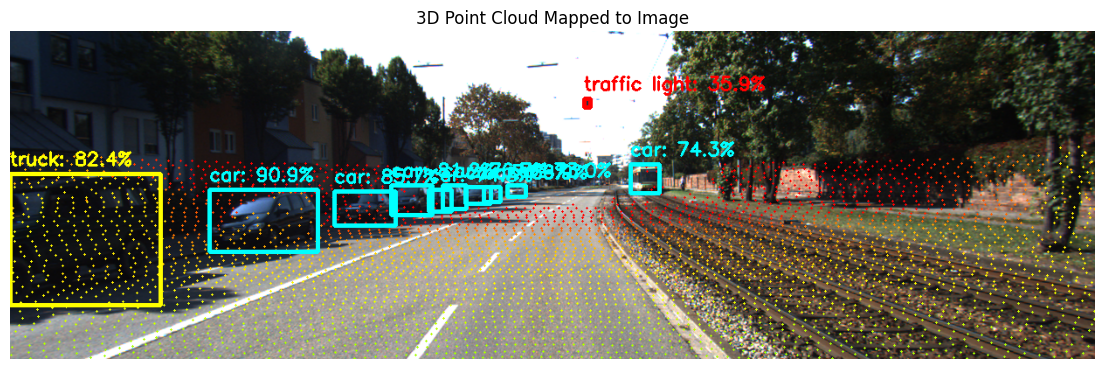

In [29]:
# Visualize the perspective view
plt.figure(figsize=(14, 7))
plt.imshow(img_with_lidar)
plt.title("3D Point Cloud Mapped to Image")
plt.axis('off')
plt.show()

In [33]:
# Create Bird's-Eye View
def create_birds_eye_view(points_3d, detected_objects, x_range=(-20, 50), y_range=(-30, 30), grid_size=0.1):
    # Filter points within the specified range
    mask = (points_3d[:, 0] >= x_range[0]) & (points_3d[:, 0] <= x_range[1]) & \
           (points_3d[:, 1] >= y_range[0]) & (points_3d[:, 1] <= y_range[1])
    points_3d = points_3d[mask]

    # Create a 2D grid
    x_bins = int((x_range[1] - x_range[0]) / grid_size)
    y_bins = int((y_range[1] - y_range[0]) / grid_size)
    bev_map = np.zeros((x_bins, y_bins))

    # Map points to the grid (accumulate height or count)
    for point in points_3d:
        x, y, z = point
        x_idx = int((x - x_range[0]) / grid_size)
        y_idx = int((y - y_range[0]) / grid_size)
        if 0 <= x_idx < x_bins and 0 <= y_idx < y_bins:
            bev_map[x_idx, y_idx] += 1  # Count points (can use z for height)

    # Normalize the BEV map for visualization
    bev_map = np.log1p(bev_map)  # Log scale for better visualization

    # Plot the BEV
    plt.figure(figsize=(10, 10))
    plt.imshow(bev_map.T, cmap='viridis', origin='lower',
               extent=[x_range[0], x_range[1], y_range[0], y_range[1]])

    # Plot the vehicle position (at origin)
    plt.scatter([0], [0], color='red', s=100, label='Vehicle', marker='^')

    # Plot detected objects with z-coordinate in the label
    for obj in detected_objects:
        x, y, z = obj["center"]  # Now includes z
        color = [c/255 for c in obj["color"]]  # Normalize color for Matplotlib
        plt.scatter(x, y, color=color, s=200, label=obj["class"], alpha=0.7)
        # Include z-coordinate in the label
        plt.text(x, y+1, f"{obj['class']} ({obj['confidence']*100:.1f}%), z={z:.2f}m", color='white')

    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.title("Bird's-Eye View")
    plt.legend()
    plt.grid(True)
    plt.show()

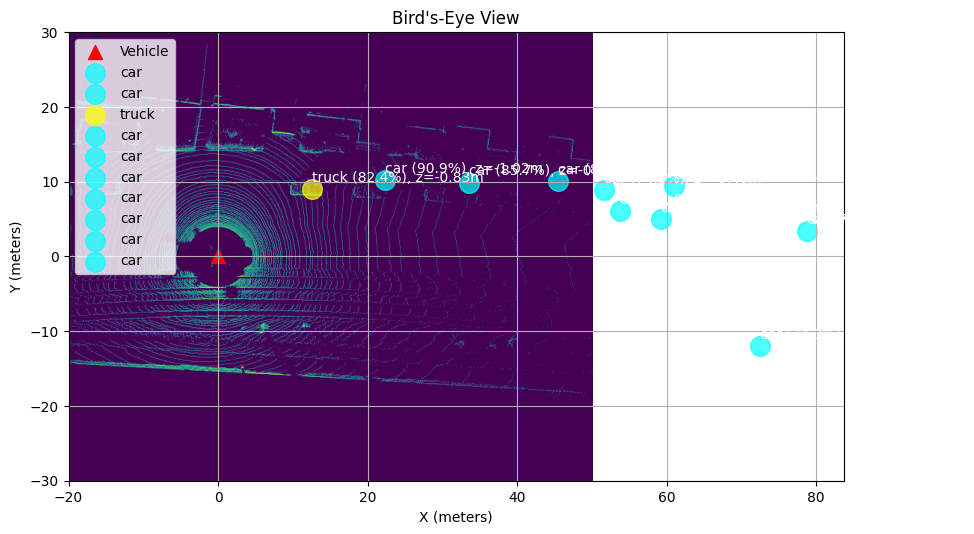

In [34]:
# Generate the bird's-eye view
create_birds_eye_view(points_3d_full, detected_objects)

In [35]:
# Print the (x, y, z) coordinates of detected objects
print("Detected Objects with (x, y, z) Coordinates:")
for obj in detected_objects:
    x, y, z = obj["center"]
    print(f"{obj['class']} ({obj['confidence']*100:.1f}%): (x={x:.2f}, y={y:.2f}, z={z:.2f})")

Detected Objects with (x, y, z) Coordinates:
car (90.9%): (x=22.35, y=10.19, z=-1.02)
car (85.7%): (x=33.64, y=9.86, z=-0.90)
truck (82.4%): (x=12.53, y=8.96, z=-0.83)
car (81.2%): (x=45.53, y=10.08, z=-0.38)
car (76.7%): (x=61.00, y=9.36, z=-0.11)
car (74.3%): (x=51.62, y=8.86, z=-0.40)
car (74.3%): (x=72.46, y=-11.97, z=1.32)
car (73.0%): (x=78.74, y=3.35, z=-0.42)
car (71.9%): (x=53.81, y=6.04, z=-0.93)
car (66.9%): (x=59.23, y=5.00, z=-0.63)
